In [1]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np

% matplotlib inline

In [2]:
N = 100; Ne = int( 0.8*N ); Ni = int( 0.2*N );

T = 4; # total time we want to simulate, 4 s
dt = 0.001; # 1 ms temporal resolution

time = np.linspace(dt,T, int(T/dt)) # time in ms

In [3]:
# decide which 20% neurons are inhibitory
inhibitory_indx = np.sort(np.random.choice(range(N),Ni,replace=False))
inhibitory_indx

array([ 2, 20, 29, 31, 35, 36, 48, 51, 53, 55, 59, 62, 66, 68, 73, 75, 76,
       77, 89, 94])

In [4]:
J0 = 0.3; J1 = 0.4; l = 0.2
sigma = 1.8

# i-d array, storing the position of each neuron
positions = np.linspace(0,1,N,endpoint=False)

# pre-define Jij_ex
Jij_ex = np.zeros([N, N])

In [5]:
def sigmoid(x):
    z = 1 / (1 + np.exp(-x))
    return z

In [6]:
# Equ. 8
def sigma_ij_comp(i,j,sigma):
    if i<j:
        result = 1
    else:
        result = sigma
    return result

In [7]:
def Jij_ex_comp(i, j):
    sigma_ij = sigma_ij_comp(i,j,sigma)
    result = sigma_ij * J1 * np.exp(-np.abs(positions[i]-positions[j])/l)
    return result

In [8]:
def Jij_in_comp(i, j):
    sigma_ij = sigma_ij_comp(i,j,sigma)
    result = sigma_ij * J2 * np.exp(-np.abs(positions[i]-positions[j])/l)
    return result

In [9]:
x0 = time/len(time)
I0 = 1.02
lambda_e = 0.03
lambda_i = 0.02
Vres = 0.85
theta = 1
J2 = 0.02
s_ex = 0.2
s_in = 0.7

In [10]:
# compute each element of Jij_ex, treat Jij_ex as a constant matrix
for ii in range(N):
    for jj in range(N):
        Jij_ex[ii,jj] = Jij_ex_comp(ii,jj)
    
Jij_ex

array([[0.72      , 0.38049177, 0.36193497, ..., 0.00313135, 0.00297863,
        0.00283336],
       [0.68488519, 0.72      , 0.38049177, ..., 0.0032919 , 0.00313135,
        0.00297863],
       [0.65148294, 0.68488519, 0.72      , ..., 0.00346068, 0.0032919 ,
        0.00313135],
       ...,
       [0.00563643, 0.00592542, 0.00622922, ..., 0.72      , 0.38049177,
        0.36193497],
       [0.00536154, 0.00563643, 0.00592542, ..., 0.68488519, 0.72      ,
        0.38049177],
       [0.00510005, 0.00536154, 0.00563643, ..., 0.65148294, 0.68488519,
        0.72      ]])

In [11]:
# compute each element of Jij_in, treat Jij_in as a constant matrix
Jij_in = np.zeros([N, N])
for ii in range(N):
    for jj in range(N):
        Jij_in[ii,jj] = Jij_in_comp(ii,jj)
    
Jij_in

array([[0.036     , 0.01902459, 0.01809675, ..., 0.00015657, 0.00014893,
        0.00014167],
       [0.03424426, 0.036     , 0.01902459, ..., 0.00016459, 0.00015657,
        0.00014893],
       [0.03257415, 0.03424426, 0.036     , ..., 0.00017303, 0.00016459,
        0.00015657],
       ...,
       [0.00028182, 0.00029627, 0.00031146, ..., 0.036     , 0.01902459,
        0.01809675],
       [0.00026808, 0.00028182, 0.00029627, ..., 0.03424426, 0.036     ,
        0.01902459],
       [0.000255  , 0.00026808, 0.00028182, ..., 0.03257415, 0.03424426,
        0.036     ]])

In [12]:
# Equ. 9
I_ext_ex = np.zeros([Ne, len(time)])

for i in range(Ne):
    for t in range(len(time)):
        I_ext_ex[i,t] = I0 * (1 + lambda_e*np.exp(-np.abs(positions[i]-x0[t])/l))
I_ext_ex

array([[1.05059996, 1.05059992, 1.05059989, ..., 1.05044746, 1.05044742,
        1.05044738],
       [1.04910766, 1.04910769, 1.04910773, ..., 1.04925345, 1.04925349,
        1.04925352],
       [1.04768806, 1.04768809, 1.04768813, ..., 1.04782674, 1.04782678,
        1.04782681],
       ...,
       [1.02065116, 1.02065116, 1.02065116, ..., 1.02065442, 1.02065442,
        1.02065442],
       [1.0206194 , 1.0206194 , 1.0206194 , ..., 1.02062251, 1.02062251,
        1.02062251],
       [1.02058919, 1.0205892 , 1.0205892 , ..., 1.02059215, 1.02059215,
        1.02059215]])

In [13]:
# Equ. 10
I_ext_in = np.zeros(len(time))

for t in range(len(time)):
    I_ext_in[t] = I0 * (1 + lambda_i * np.cos(2*np.pi*time[t]*6)) # 6-9 Hz

I_ext_in

array([1.04038551, 1.04034204, 1.04026967, ..., 1.04034204, 1.04038551,
       1.0404    ])

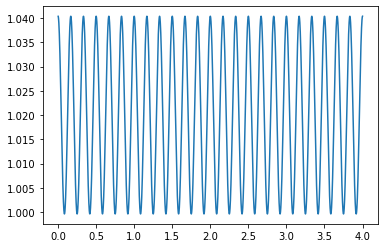

In [14]:
plt.plot(time, I_ext_in)

In [15]:
# I_ext = combine I_ext_ex and I_ext_in
I_ext = np.zeros([N, len(time)])
cnt_ex = 0
cnt_in = 0
for i in range(N):
    if i in inhibitory_indx:
        I_ext[i,:] = I_ext_in
        cnt_in = cnt_in + 1
    else:
        I_ext[i,:] = I_ext_ex[cnt_ex,:]
        cnt_ex = cnt_ex + 1

In [16]:
def delta_kronecker(delta_t):
    if delta_t == 0:
        return 1
    else:
        return 0

In [17]:
# compute I_ex and I_in
I_ex = np.zeros([N, len(time)])
I_in = np.zeros([N, len(time)])

t_spike = np.zeros([N, len(time)])

Is = np.zeros([N, len(time)])

V = np.zeros([N, len(time)])
V[:,0] = Vres

In [18]:
tau_ex = 6/1000
tau_in = 4/1000
tau = 20/1000

In [19]:
def integrate_and_fire(V, t_spike_time, t, Is):
    dV = dt*(-V[:,t-1] + Is[:,t-1] + I_ext[:,t-1])/tau
    V[:,t] = V[:,t-1] + dV
    for i in range(N):
        if V[i,t]>theta:
            t_spike_time[i,t] = 1
            V[i,t] = Vres
            
        if i in inhibitory_indx:
            I_in[i,t] = I_in[i,t-1] + dt*(-I_in[i,t-1]/tau_in + s_in*np.dot(Jij_in[i,:],t_spike_time[:,t-1]))
        else:
            I_ex[i,t] = I_ex[i,t-1] + dt*(-I_ex[i,t-1]/tau_ex + s_ex*np.dot(Jij_ex[i,:],t_spike_time[:,t-1]))
            
    Is = I_ex - I_in
    
    return V, t_spike_time, Is

In [20]:
for t in range(1,len(time)):
    V, t_spike, Is = integrate_and_fire(V, t_spike, t, Is)
    

In [21]:
t_spike

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

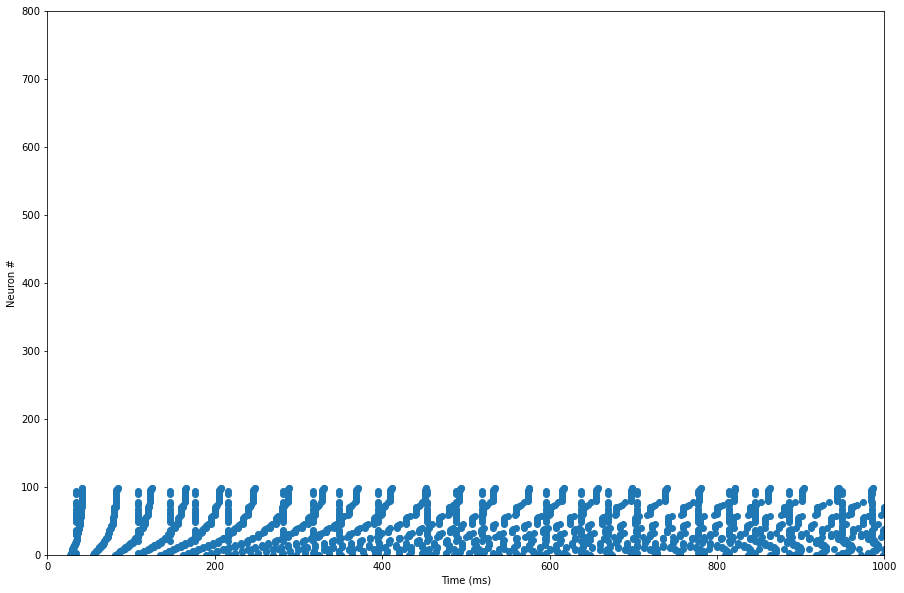

In [26]:
plt.figure(figsize=(15,10))
plt.xlabel('Time (ms)')
plt.ylabel('Neuron #')
plt.xlim([0, 1000])
plt.ylim([0,800])
plt.scatter(np.where(t_spike==1)[1], np.where(t_spike==1)[0])

In [23]:
np.where(t_spike==1)[1]

array([  27,   54,   81, ..., 3898, 3939, 3980])